In [53]:
!wget "http://elib.zib.de/pub/mp-testdata/tsp/tsplib/tsp/st70.tsp"

import numpy as np
import math
import random
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

--2020-02-17 11:39:41--  http://elib.zib.de/pub/mp-testdata/tsp/tsplib/tsp/st70.tsp
Resolving elib.zib.de (elib.zib.de)... 130.73.108.67
Connecting to elib.zib.de (elib.zib.de)|130.73.108.67|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 734 [text/plain]
Saving to: ‘st70.tsp.7’

st70.tsp.7          100%[===================>]     734  --.-KB/s    in 0s      

2020-02-17 11:39:41 (168 MB/s) - ‘st70.tsp.7’ saved [734/734]



In [0]:
### Start-up ###

# Load in city coordinates
CITY_COORDS = []
with open("st70.tsp", 'r') as prob:
    for i, line in enumerate(prob):
        
        #Hardcode the 70 lines that contain the cities
        if i > 5 and i < 76:
            values = line.split()[1:]
            values = [int(val) for val in values]
            CITY_COORDS.append(values)

N_CITIES = len(CITY_COORDS)

In [0]:
# Determine distance between two cities
def distance(A, B) -> float:
    return math.sqrt((A[0]-B[0])**2 + (A[1]-B[1])**2)


# Evaluate fitness of genotypes
def fitness (cityList, coords=CITY_COORDS):
    totalDistance = 0
    for i in range(len(cityList)-1):
        cityA = int(cityList[i])
        cityB = int(cityList[i+1])
        aX, aY = coords[cityA]
        bX, bY = coords[cityB]
        distance = np.sqrt((bX - aX)**2 + (bY - aY)**2)
        totalDistance += distance
    return totalDistance


# For each city in the list, switch with other randomly chosen city in the list with probability pm
def mutate(cities, pm=0.01):
    
    for i in range(len(cities)):
        if pm > np.random.rand():

            randcity = np.random.randint(len(cities))

            a = cities[i]
            b = cities[randcity]
            cities[i] = b
            cities[randcity] = a

    return cities


def crossoverV2(cityList1, cityList2):
    assert len(cityList1) == len(cityList2)
    n_cities = len(cityList1)

    #Get cutpoints
    cutpoint1 = np.random.randint(0, n_cities)
    cutpoint2 = np.random.randint(0, n_cities)
    while cutpoint2 == cutpoint1:                   #Cutpoints must not be equal
        cutpoint2 = np.random.randint(0, n_cities)
    tempmin = min(cutpoint1, cutpoint2)             #Determine which cutpoint is the smallest
    cutpoint2 = max(cutpoint1, cutpoint2)
    cutpoint1 = tempmin

    # Copy cutsection from first parent
    child = cityList1[cutpoint1:cutpoint2]

    # Get missing cities
    missing = cityList2
    for city in child:
        missing.remove(city)

    # Prepend and append missing cities into child
    for i in range(cutpoint1):
        child.insert(i, missing[i])

    for i in range(n_cities - cutpoint2):
        child.append(missing[i+cutpoint1])

    return child


# Select two parents through binary-tournament selection
def binaryTournament(cities_list):
    parents = (cities_list[np.random.randint(N)], cities_list[np.random.randint(N)])
    if fitness(parents[0]) < fitness(parents[1]):
        p1 = parents[0]
    else:
        p1 = parents[1]

    parents = (cities_list[np.random.randint(N)], cities_list[np.random.randint(N)])
    if fitness(parents[0]) < fitness(parents[1]):
        p2 = parents[0]
    else:
        p2 = parents[1]

    return list(p1), list(p2)

def forceMutation(cities):
    ind = np.arange(len(cities))
    swaps = np.random.choice(ind,2)
    test = cities[swaps[0]]
    cities[swaps[0]]= cities[swaps[1]]
    cities[swaps[1]] = test
    return cities

#force some mutations and return the best cityList.
def localSearch(cityList, coords=CITY_COORDS):
    searchOptions = 20
    bestCity = cityList.copy()
    for i in range(searchOptions):
        test = forceMutation(cityList)
        if (fitness(test,coords) < fitness(bestCity,coords)):
            bestCity = test
    return bestCity

In [57]:
### The actual program ###

N = 30
epochs = 1000

# Randomly Initialize population
population = []
for i in range(N):
    individual = [i for i in range(70)]
    np.random.shuffle(individual)
    population.append(list(individual))

populationMemetic = population.copy()

populationfitness = []
popfitplot = []
popfitbest = []
for i in tqdm(range(epochs)):
    children = []
    for j in range(N):
        parents = binaryTournament(population)
        
        child = crossoverV2(*parents)
        child = mutate(child)
        children.append(child)
        
    # Pair-wise elitism
    # for j in range(N):
    #     if fitness(children[j]) < fitness(population[j]):
    #         population[j] = children[j]


    # Selection by absolutist elitism  
    population.extend(children)
    population = sorted(population, key=fitness)[:N]
    

    popfitness = 0
    for j in range(N):
      popfitness += fitness(population[j])

    populationfitness.append(popfitness)
    popfitplot.append(popfitness)
    popfitbest.append(fitness(population[0]))

[101838.90143091073, 96727.582811567, 94557.66925479227, 91595.13722843111, 89752.50090768893, 87545.61279279542, 85376.19552954551, 82985.9409296078, 80676.59648092807, 79265.34592665476, 77998.8405932744, 76880.12798270836, 75667.72906438397, 74534.64186104931, 73246.02603423818, 72367.17559622938, 71476.60729504547, 70075.20196712304, 69330.81652794156, 67897.16923050131, 66381.44544694196, 65319.31396531627, 64846.24831055384, 64475.140351684655, 64007.99840582031, 63545.40879841198, 63158.57901339676, 62611.05237087902, 62036.86101490866, 61673.60949210913, 60909.226435216624, 60169.06638921145, 59715.56662120023, 59325.6240091125, 58704.16893450324, 58364.04913913771, 58125.519929965376, 57863.08479741524, 57701.70135367238, 57550.74095583468, 57533.94793812116, 57459.20774408591, 57395.37961319623, 57341.43026381304, 57279.21405009102, 57194.4963119546, 57095.26547349099, 56951.84386279277, 56843.0268385573, 56756.7129974812, 56638.59221432911, 56528.182182720986, 56348.58535193

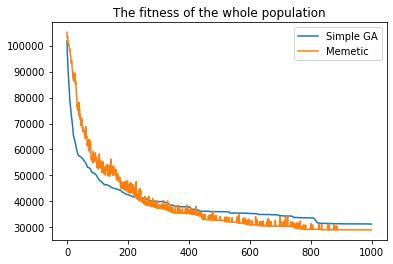

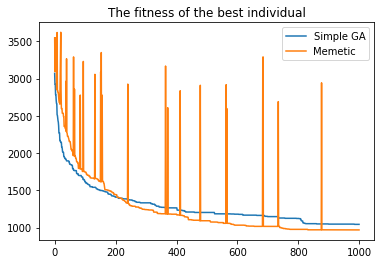

In [58]:
### Memetic version ###


populationfitness = []
popfitplotMemetic = []
popfitbestMemetic = []
for i, j in enumerate(populationMemetic):
    populationMemetic[i] = localSearch(j)

for i in tqdm(range(epochs)):
    children = []
    for j in range(N):

        parents = binaryTournament(populationMemetic)
        child = crossoverV2(*parents)
        child = mutate(child)
        
        children.append(child)
        
    # Pair-wise elitism
    # for j in range(N):
    #     if fitness(children[j]) < fitness(population[j]):
    #         population[j] = children[j]


    # Selection by absolutist elitism  
    populationMemetic.extend(children)
    populationMemetic = sorted(populationMemetic, key=fitness)[:N]
    
    for i, j in enumerate(populationMemetic):
      populationMemetic[i] = localSearch(j)

    popfitness = 0
    for j in range(N):
      popfitness += fitness(populationMemetic[j])

    populationfitness.append(popfitness)
    popfitplotMemetic.append(popfitness)
    popfitbestMemetic.append(fitness(populationMemetic[0]))


print(popfitplot)
print(popfitbest)
print(popfitplotMemetic)
print(popfitbestMemetic)

x = np.arange(epochs)
plt.plot(x, popfitplot)
plt.plot(x, popfitplotMemetic)

plt.legend(['Simple GA', 'Memetic'], loc='upper right')
plt.title('The fitness of the whole population')
plt.show()

plt.plot(x, popfitbest)
plt.plot(x, popfitbestMemetic)

plt.legend(['Simple GA', 'Memetic'], loc='upper right')
plt.title('The fitness of the best individual')
plt.show()